In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from src.pipeline import find_flux, find_noise_square
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")

In [16]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

# Set the aperture size (pixels)
aperture_size = 8

In [15]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

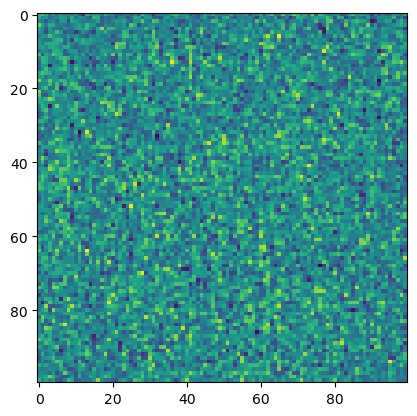

In [6]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    y0_rubin, x0_rubin, y1_rubin, x1_rubin = find_noise_square(hdul[1].data, 100)
    plt.imshow(hdul[1].data[y0_rubin:y1_rubin, x0_rubin:x1_rubin])
    plt.show()

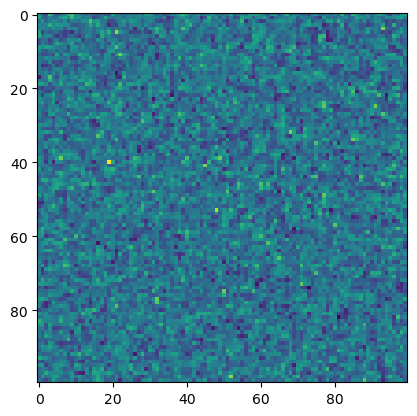

In [8]:
catalog = Table.read(f'{location}/{field}/VIS.cat', format='fits', hdu=2)
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[0]
    y0_euclid, x0_euclid, y1_euclid, x1_euclid = find_noise_square(hdul[0].data[:3400, :3400], 100)
    plt.imshow(hdul[0].data[y0_euclid:y1_euclid, x0_euclid:x1_euclid])
    plt.show()

In [ ]:
rubin_filters = ['u', 'g', 'r', 'i', 'z', 'y']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']

In [20]:
np.linspace(2, 12, 20)

array([ 2.        ,  2.52631579,  3.05263158,  3.57894737,  4.10526316,
        4.63157895,  5.15789474,  5.68421053,  6.21052632,  6.73684211,
        7.26315789,  7.78947368,  8.31578947,  8.84210526,  9.36842105,
        9.89473684, 10.42105263, 10.94736842, 11.47368421, 12.        ])

In [37]:
np.linspace(2, 12, 10)

array([ 2.        ,  3.11111111,  4.22222222,  5.33333333,  6.44444444,
        7.55555556,  8.66666667,  9.77777778, 10.88888889, 12.        ])

In [ ]:
fluxes = {}

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference

rubin_filters = ['g', 'r', 'i']
euclid_filters = ['DES-G', 'DES-R', 'DES-I']

for filter in rubin_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]
    psf_file = [f for f in files if f.endswith("psf.fits")][0]

    flux_values, sigma = find_flux(
        image_file,
        "Rubin",
        aperture_size,
        ra_reference,
        dec_reference,
        psf_path=psf_file,
        correlated=1,
        noise_x0=x0_rubin,
        noise_x1=x1_rubin,
        noise_y0=y0_rubin,
        noise_y1=y1_rubin
    )

    sigma_values = np.full(len(flux_values), sigma)
    fluxes[filter] = flux_values
    fluxes[f'{filter}_sigma'] = sigma_values
    
for filter in euclid_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]
    flux_values, sigma = find_flux(
        image_file,
        "Euclid",
        aperture_size,
        ra_reference,
        dec_reference,
        catalog_path=f'{location}/{field}/{filter}.cat',
        tilesize=600,
        correlated=1,
        noise_x0=x0_euclid,
        noise_x1=x1_euclid,
        noise_y0=y0_euclid,
        noise_y1=y1_euclid
    )

    sigma_values = np.full(len(flux_values), sigma)
    fluxes[filter] = flux_values
    fluxes[f'{filter}_sigma'] = sigma_values

Analyzing image
Analyzing image
Analyzing image
Analyzing image
Creating PSF
Processing x=(18600,19200), y=(18600,19200)           
Analyzing image
Creating PSF
Processing x=(18600,19200), y=(18600,19200)           
Analyzing image
Creating PSF
Processing x=(18600,19200), y=(18600,19200)           


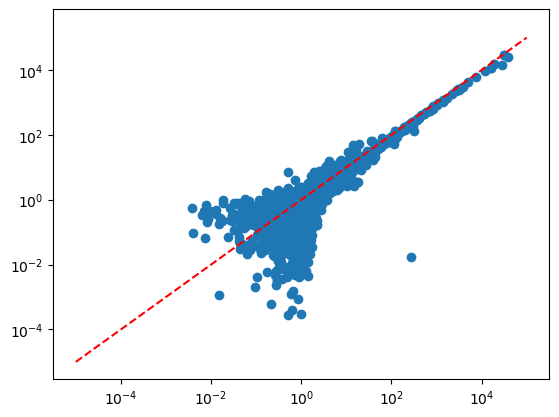

In [23]:
plt.scatter(fluxes['g'], fluxes['DES-G'])
plt.plot([1e-5, 1e5], [1e-5, 1e5], color='red', linestyle='--')
plt.loglog()
plt.show()

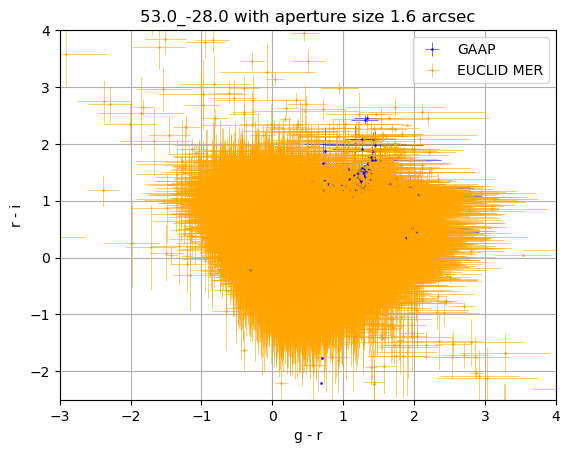

In [61]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
        (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < 1)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    gaap_error = xerr**2 + yerr**2
    # plt.show()
    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    x_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    )

    mask = (xerr**2 + yerr**2 < 1)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    euclid_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'{filter_1} - {filter_2}')
    plt.ylabel(f'{filter_3} - {filter_4}')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

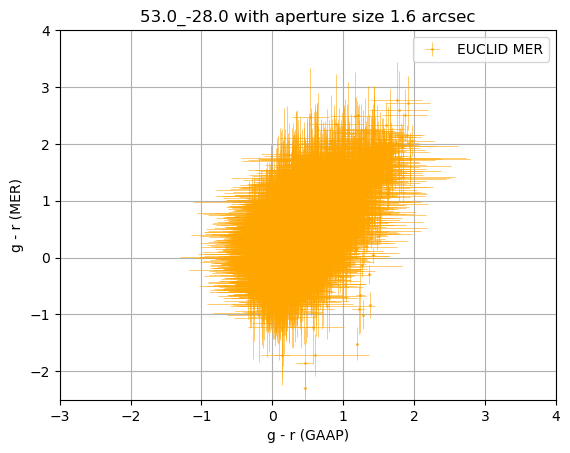

In [35]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    # y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
        (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    #     (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
    # )

    # Optional: filter points with very large errors
    # mask = (xerr**2 + yerr**2 < 1)
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # gaap_error = xerr**2 + yerr**2
    # # plt.show()
    # # Plot
    # plt.errorbar(
    #     x_color[mask], y_color[mask],
    #     xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    #     fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    # )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    y_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    # y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
    #     (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    # )

    mask = (xerr**2 + yerr**2 < 1)
    # new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    # euclid_error = xerr**2 + yerr**2
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'g - r (GAAP)')
    plt.ylabel(f'g - r (MER)')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

In [23]:
print(np.sum(np.isnan(euclid_error)))

16


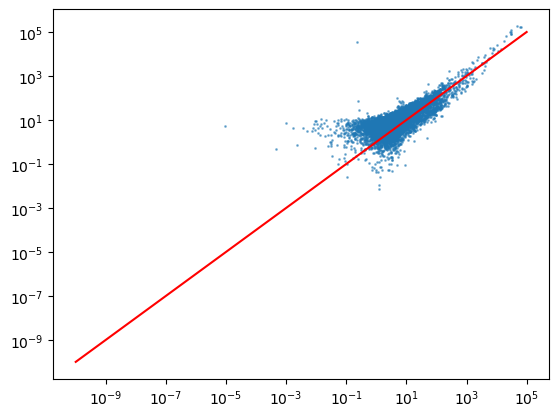

In [67]:
plt.scatter(fluxes['DES-G'], fluxes['g']*4, s=1, alpha=0.5)
plt.loglog()
plt.plot([1e-10, 1e5], [1e-10, 1e5], '-', c='r', label='Equality')

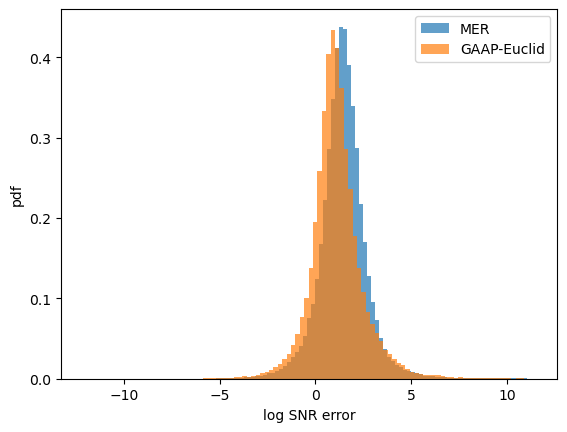

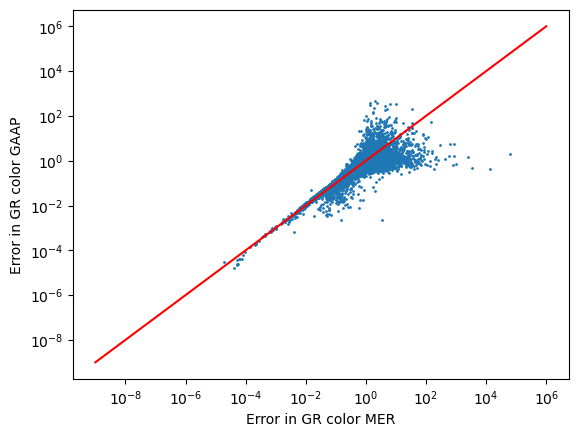

0.48070378683657955


In [60]:
plt.hist(np.log(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUXERR_G_EXT_DECAM_2FWHM_APER']), bins=100, density=True, alpha=0.7, label='MER')
# plt.hist(np.log(fluxes['g'][fluxes['g']>0]/fluxes['g_sigma'][fluxes['g']>0]), bins=100, density=True, alpha=0.7, label='GAAP-Rubin')
plt.hist(np.log(fluxes['DES-G'][fluxes['DES-G']>0]/fluxes['DES-G_sigma'][fluxes['DES-G']>0]), bins=100, density=True, alpha=0.7, label='GAAP-Euclid')
plt.xlabel('log SNR error')
plt.ylabel('pdf')
plt.legend()
plt.show()
plt.scatter(yerr, xerr, s=1)
plt.plot([1e-9, 1e6], [1e-9, 1e6], '-', c='r', label='Equality')
plt.loglog()
plt.xlabel('Error in GR color MER')
plt.ylabel('Error in GR color GAAP')
plt.show()
print(np.sum(xerr[np.isfinite(xerr)] < yerr[np.isfinite(xerr)])/len(xerr[np.isfinite(xerr)]))
# print(np.sum(xerr>yerr), np.sum(xerr<yerr))

In [54]:
fluxes

{'ra': <Column name='RIGHT_ASCENSION' dtype='float64' length=96164>
 53.157185309341294
  52.81636181615536
  52.70722717588816
  52.76128009920175
  53.23377168931079
  53.23413830733967
  52.98112913512771
  52.98104780921814
 53.014370028813204
  52.74040091688509
 52.761032133298194
  52.76066285491598
                ...
 52.773803357344065
   53.1454867699925
 52.739464057247126
  53.21280344758405
  52.79395506691152
  52.77344174528453
  52.76220412027244
 53.002812824131254
  53.00264070874322
 52.751111252080584
  53.06944755495356,
 'dec': <Column name='DECLINATION' dtype='float64' length=96164>
 -28.254256719410495
   -28.2540116239448
 -28.253847077261902
  -28.25392417422625
 -28.253921167460266
 -28.253729805026264
 -28.254034563298426
 -28.253836897530146
 -28.253766432236183
 -28.253478239808153
 -28.253554699863198
 -28.253402861061705
                 ...
 -27.748700011854766
 -27.748711827585165
  -27.74852487493215
 -27.748718699047483
 -27.748415022924057
 -27.748

Analyzing image
Analyzing image
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvolving weight function
Analyzing image
Deconvo

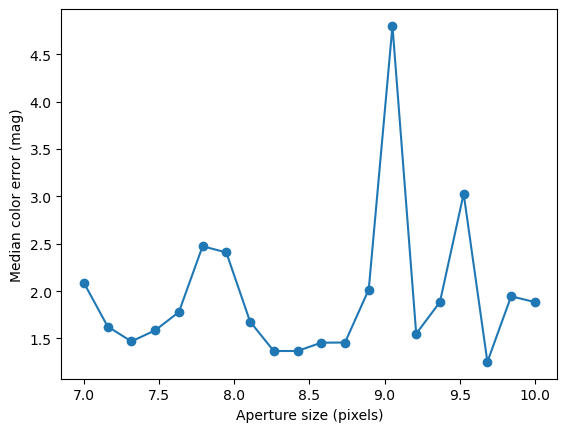

In [9]:
sizes = np.linspace(7, 10, 20)
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filters = [filter_1, filter_2]
color_errors = np.zeros_like(sizes)
color_errors[:] = np.nan
fluxes = {}
sigmas = {}
for i, size in enumerate(sizes):
    for filter in filters:
        files = glob.glob(f'{location}/{field}/{filter}_*.fits')
        image_file = [file for file in files if not file.endswith("psf.fits")][0]
        psf_file = [file for file in files if file.endswith("psf.fits")][0]
        fluxes[filter], sigmas[filter] = find_flux(image_file, "Rubin", size, ra_reference, dec_reference, psf_path=psf_file, correlated=2, noise_x0=x0_rubin, noise_x1=x1_rubin, noise_y0=y0_rubin, noise_y1=y1_rubin)
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_1] / fluxes[filter_1])**2 +
        (sigmas[filter_2] / fluxes[filter_2])**2
    )
    color_errors[i] = np.nanmean(xerr[np.isfinite(xerr)])
plt.plot(sizes, color_errors, '-o')
plt.xlabel('Aperture size (pixels)')
plt.ylabel('Median color error (mag)')
plt.show()

In [11]:
print(sizes[np.nanargmin(color_errors[sizes<=9])])

8.263157894736842
